# Exploratory Analisys

## Context

This notebook aims to explore the linear structure of average  temperature over time as a preparatory step for building a hybrid forecast model. By analyzing trend, seasonal patterns and linear temporal dependence we seek to understand how much of the temperature variability can be explained by linear components. The non-linear structure will be analize in an second notebook.

**Data Source**
The data used in this notebook was extracted from the notebook *sanity-check.ipynb*

- **Data:** 16/08/2025
- **Localização:** ../data/wrangle

## Set up

### Libraries

In [1]:
## Base
import os
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Statistic
import scipy
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.quantile_regression import QuantReg

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[0].as_posix())

from src.ts_utils import *

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

## Data
For this project, the data are divided into four sets: train, validation, conformal prediction and test. To prevent information leakage into later stages, our exploratory analysis will initially focus exclusively on the train set.

In [4]:
df = pd.read_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_sanitized.parquet'))

df_test = df.tail(365).copy()
df_cp = df.head(len(df) - 365).tail(2 * 365).copy()
df_valid = df.head(len(df) - 3 * 365).tail(2 * 365).copy()
weather_df = df.head(len(df) - 5 * 365).copy()

In [5]:
df_test.to_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_test.parquet'))
df_cp.to_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_conformal_prediction.parquet'))
df_valid.to_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_validation.parquet'))

The data is split as follows: 5 years for training, 2 years for validation, 2 years for conformal prediction and 1 year for testing.

In [6]:
display(weather_df.tail())
weather_df.info()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal
1813,2020-08-05,293.1,0.0,0.0,3.1,1018.8,10.5,Southwest
1814,2020-08-06,295.6,0.0,0.0,2.4,1018.9,8.4,East
1815,2020-08-07,296.5,0.0,0.0,2.4,1019.8,12.2,Southeast
1816,2020-08-08,298.4,0.0,0.0,4.3,1018.7,11.3,South
1817,2020-08-09,300.3,0.0,0.0,5.1,1015.8,10.0,South


<class 'pandas.core.frame.DataFrame'>
Index: 1818 entries, 0 to 1817
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       1818 non-null   datetime64[ns]
 1   tavg       1818 non-null   float64       
 2   prcp       1818 non-null   float64       
 3   snow       1818 non-null   float64       
 4   wspd       1818 non-null   float64       
 5   pres       1818 non-null   float64       
 6   tamp       1818 non-null   float64       
 7   wcardinal  1818 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(6)
memory usage: 115.8 KB


# Heteroscedastic
The first step is to address the seasonal heteroscedasticity in the data. To this end, we apply two classic variance-stabilizing transformations: logarithmic and Box–Cox, both designed to smooth the series and facilitate modeling. After transformation, we need to determine whether the transformed target or the original data is easier to forecast. To do this, we decompose the series into its seasonal and trend components before making a decision.

## Log Transformation

The logarithmic transformation is most effective when variability increases proportionally with the magnitude of the target. In our case, the relationship is inverse: variability decreases as the values increase. To account for this, we apply the transformation $log⁡(1/x)$, where $x$ represents the feature value.

In [7]:
def log_transf(serie: pd.Series):
    return serie.apply(lambda x: np.log(1/x))
def inv_log_transf(array: np.array):
    return 1/np.exp(array)

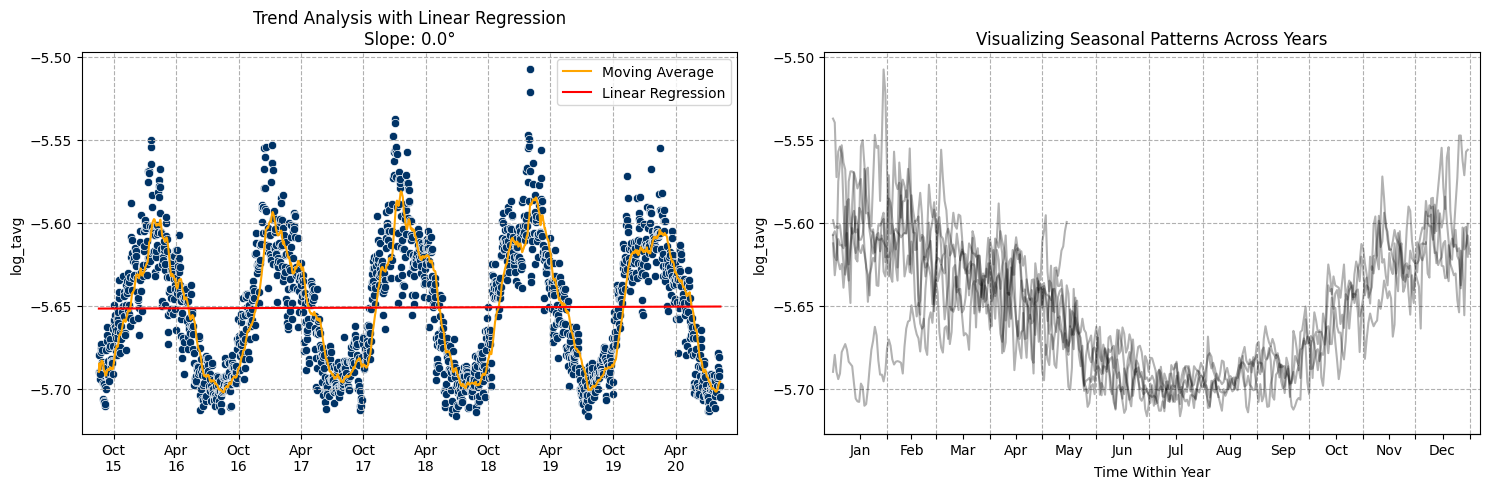

In [8]:
weather_df['log_tavg'] = log_transf(weather_df['tavg'])
ts_quick_insights(weather_df['log_tavg'], weather_df['time'])   

## Box-Cox Transformation
For the Box–Cox transformation, the same principle as for the logarithmic transformation applies. Therefore, we apply the Box–Cox transformation to $1/x$, where $x$ is the feature value. Unlike the logarithm, the Box–Cox transformation can automatically select an optimal power parameter $λ$ to stabilize variance, providing a more flexible approach to variance stabilization.

In [9]:
def box_transf(serie: pd.Series):
    return scipy.stats.boxcox(1/serie)
def inv_box_transf(serie: np.array, lmbda: float):
    return 1/scipy.special.inv_boxcox(serie, lmbda)

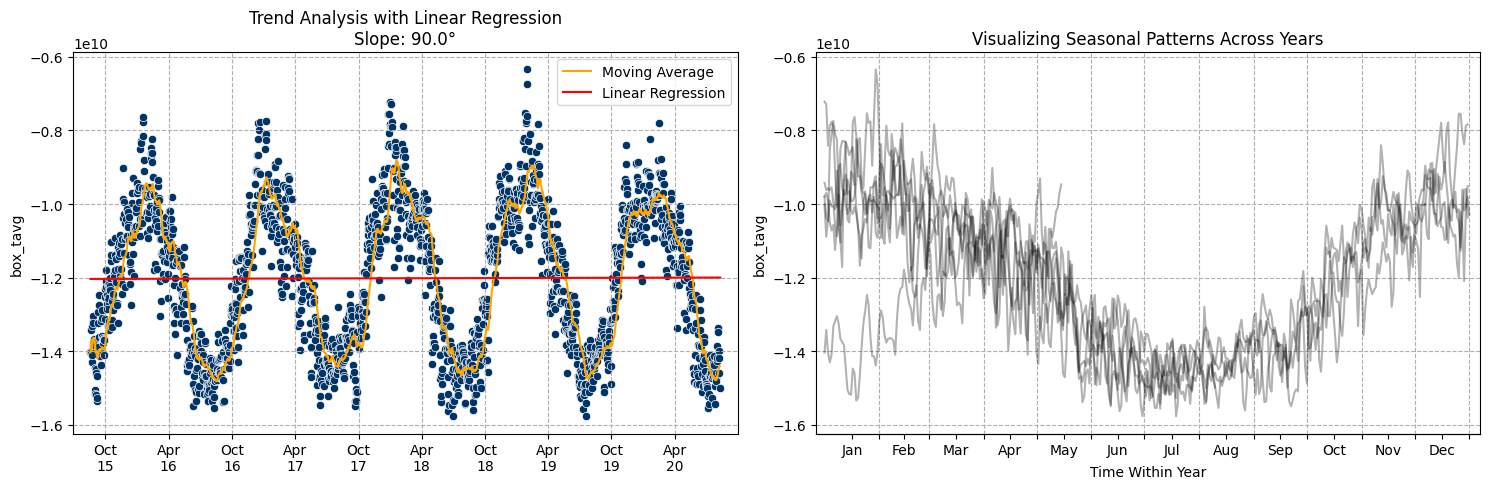

In [10]:
weather_df['box_tavg'], lmbda = box_transf(weather_df['tavg'])
ts_quick_insights(weather_df['box_tavg'], weather_df['time'])   

# Trend Decomposition
As observed in the plots, the slope of both the transformed and original data is approximately zero (or 90 degrees). Based on this, we can conclude that there is no discernible trend in any of the targets.

# Seasonal Decomposition
However, the data exhibit a clear annual seasonal pattern. Because this pattern is pronounced and we are addressing seasonal heteroscedasticity, we apply harmonic regression to model and remove the seasonal component. Additionally, to account for the heteroscedasticity, we use a quantile regression with $q=0.5$, as our main objective is to predict the temperature while minimizing the width of the prediction interval.

In [11]:
n = len(weather_df)
t = np.arange(n)

omega1 = (2 * np.pi / 365.25)
omega2 = 2 * (2 * np.pi / 365.25)
omega3 = 3 * (2 * np.pi / 365.25)

We include additional harmonic terms to ensure that all relevant seasonal patterns are captured, selecting those terms whose p-values indicate they are statistically significant for prediction ($< 0.05$).

In [12]:
residuals = pd.DataFrame() # Object to store the residuals

## Seasonal tavg
Despite the transformation, it is still premature to disregard the original data. Therefore, we will analyze it alongside the other variables on an equal footing.

In [13]:
y = weather_df['tavg'].copy()
X = np.column_stack([
    np.ones(n), # Intercept           
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

model = QuantReg(y, X)
res = model.fit(q=0.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   tavg   Pseudo R-squared:               0.6178
Model:                       QuantReg   Bandwidth:                       1.650
Method:                 Least Squares   Sparsity:                        10.09
Date:                Mon, 18 Aug 2025   No. Observations:                 1818
Time:                        22:17:40   Df Residuals:                     1811
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.8792      0.118   2408.569      0.000     284.647     285.111
x1            -5.7126      0.167    -34.230      0.000      -6.040      -5.385
x2            12.1953      0.168     72.742      0.000      11.867      12.524
x3            -0.0508      0.167     -0.304      0.761      -0.378       0.277
x4             0.6386      0.168      3.810      0.000       0.310       0.967
x5             0.2403      0.167      1.439      0.150      -0.087       0.568
x6            -0.4977      0.168     -2.969      0.003      -0.826      -0.169
==============================================================================
"""

Using a 5% significance threshold, we determined that components 3 and 5 are not statistically significant and will therefore be excluded from the prediction.

In [14]:
y = weather_df['tavg'].copy()
X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t),
    np.cos(omega3*t)
])

model = QuantReg(y, X)
res = model.fit(q=0.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   tavg   Pseudo R-squared:               0.6175
Model:                       QuantReg   Bandwidth:                       1.627
Method:                 Least Squares   Sparsity:                        9.840
Date:                Mon, 18 Aug 2025   No. Observations:                 1818
Time:                        22:17:40   Df Residuals:                     1813
                                        Df Model:                            4
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.8424      0.115   2468.285      0.000     284.616     285.069
x1            -5.6733      0.163    -34.842      0.000      -5.993      -5.354
x2            12.1703      0.164     74.403      0.000      11.849      12.491
x3             0.6374      0.164      3.897      0.000       0.317       0.958
x4            -0.5492      0.164     -3.358      0.001      -0.870      -0.228
==============================================================================
"""

Let’s examine the residuals to verify whether the regression has fitted the data as expected.

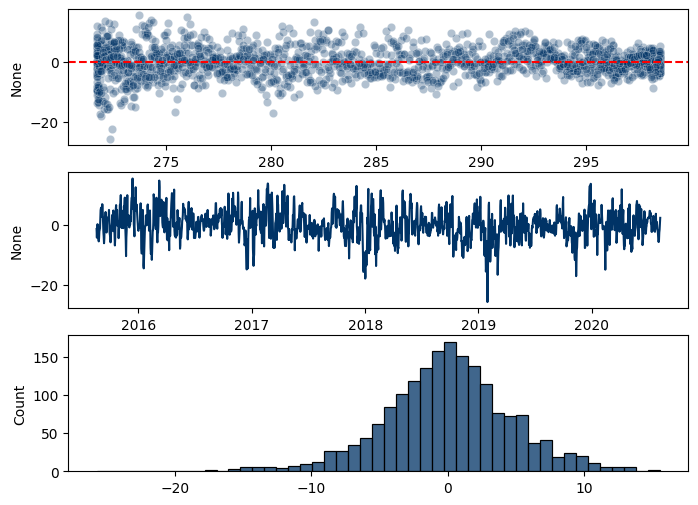

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.scatterplot(x=res.predict(X), y=res.resid, ax=ax[0], alpha=0.3)
ax[0].axhline(y=0, color='r', linestyle='--')

sns.lineplot(x=weather_df['time'], y=res.resid, ax=ax[1])

sns.histplot(res.resid, ax=ax[2])

plt.show()

As shown in the second plot, seasonal heteroscedasticity is still present in the residuals of the original data, as expected.

In [16]:
residuals['resid'] = res.resid

## Seasonal Log
Now, for the logarithmic transformation, we will examine it in the same way as the original variable.

In [17]:
log_y = weather_df['log_tavg'].copy()
log_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

log_model = QuantReg(log_y, log_X)
log_res = log_model.fit(q=0.5)
log_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               log_tavg   Pseudo R-squared:               0.6148
Model:                       QuantReg   Bandwidth:                    0.005720
Method:                 Least Squares   Sparsity:                      0.03520
Date:                Mon, 18 Aug 2025   No. Observations:                 1818
Time:                        22:17:40   Df Residuals:                     1811
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6515      0.000  -1.37e+04      0.000      -5.652      -5.651
x1             0.0201      0.001     34.484      0.000       0.019       0.021
x2            -0.0428      0.001    -73.070      0.000      -0.044      -0.042
x3            -0.0003      0.001     -0.452      0.651      -0.001       0.001
x4            -0.0019      0.001     -3.250      0.001      -0.003      -0.001
x5            -0.0009      0.001     -1.461      0.144      -0.002       0.000
x6             0.0017      0.001      2.981      0.003       0.001       0.003
==============================================================================
"""

As shown in the summary above, only the constant and components 1, 2, 4 and 6 are statistically useful for our regression.

In [18]:
log_y = weather_df['log_tavg'].copy()
log_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t),
    np.cos(omega3*t)
])

log_model = QuantReg(log_y, log_X)
log_res = log_model.fit(q=0.5)
log_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               log_tavg   Pseudo R-squared:               0.6144
Model:                       QuantReg   Bandwidth:                    0.005649
Method:                 Least Squares   Sparsity:                      0.03438
Date:                Mon, 18 Aug 2025   No. Observations:                 1818
Time:                        22:17:40   Df Residuals:                     1813
                                        Df Model:                            4
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6514      0.000   -1.4e+04      0.000      -5.652      -5.651
x1             0.0197      0.001     34.692      0.000       0.019       0.021
x2            -0.0427      0.001    -74.805      0.000      -0.044      -0.042
x3            -0.0017      0.001     -3.056      0.002      -0.003      -0.001
x4             0.0020      0.001      3.467      0.001       0.001       0.003
==============================================================================
"""

As we did previously, let’s analyze the residuals.

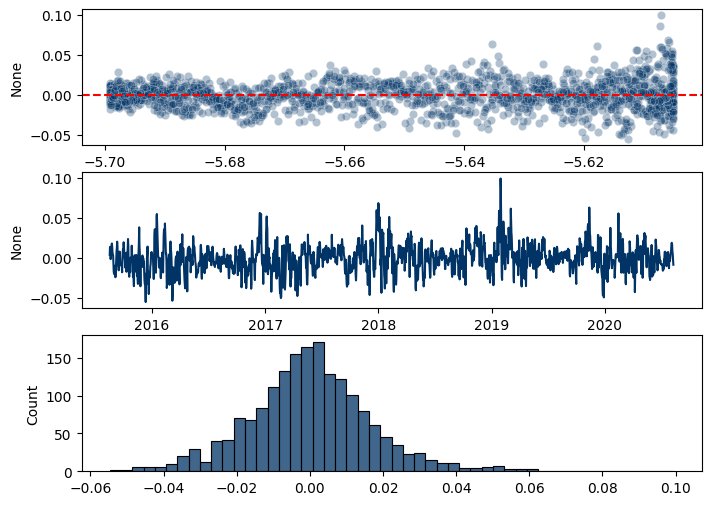

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.scatterplot(x=log_res.predict(log_X), y=log_res.resid, ax=ax[0], alpha=0.3)
ax[0].axhline(y=0, color='r', linestyle='--')

sns.lineplot(x=weather_df['time'], y=log_res.resid, ax=ax[1])

sns.histplot(log_res.resid, ax=ax[2])

plt.show()

As shown above, despite our efforts, the transformation was unable to eliminate the heteroscedasticity, which continues to be present in the residuals.

In [20]:
log_predict = inv_log_transf(log_res.predict(log_X))
residuals['log_resid'] = weather_df['tavg'] - log_predict

## Seasonal Box-Cox
The Box–Cox transformation has already been applied, and we will now run the harmonic regression on this transformed data, including all harmonic components.

In [21]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

box_model = QuantReg(box_y, box_X)
box_res = box_model.fit(q=0.5)
box_res.summary()

/home/pedro.moura/Pessoal/WeatherForecast/venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               box_tavg   Pseudo R-squared:               0.6261
Model:                       QuantReg   Bandwidth:                   3.084e+08
Method:                 Least Squares   Sparsity:                    1.860e+09
Date:                Mon, 18 Aug 2025   No. Observations:                 1818
Time:                        22:17:40   Df Residuals:                     1811
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.201e+10   2.18e+07   -550.347      0.000    -1.2e+10    -1.2e+10
x1          1.046e+09   3.08e+07     33.969      0.000    9.85e+08    1.11e+09
x2         -2.239e+09   3.09e+07    -72.393      0.000    -2.3e+09   -2.18e+09
x3          7.863e+07   3.08e+07      2.554      0.011    1.83e+07    1.39e+08
x4         -1.733e+08   3.09e+07     -5.606      0.000   -2.34e+08   -1.13e+08
x5          -3.84e+07   3.08e+07     -1.247      0.213   -9.88e+07     2.2e+07
x6          8.325e+07   3.09e+07      2.693      0.007    2.26e+07    1.44e+08
==============================================================================
"""

Unlike the regressions above, the statistically significant components here are 1, 2, 3, 4 and 6. Component 3, which was not significant in the previous regressions, is significant in this case — a positive development, as it may indicate additional information that can contribute to improved predictions.

In [22]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.cos(omega3*t)
])

box_model = QuantReg(box_y, box_X)
box_res = box_model.fit(q=0.5, method='simplex', max_iter=100000)
box_res.summary()

/home/pedro.moura/Pessoal/WeatherForecast/venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (100000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               box_tavg   Pseudo R-squared:               0.6259
Model:                       QuantReg   Bandwidth:                   3.044e+08
Method:                 Least Squares   Sparsity:                    1.822e+09
Date:                Mon, 18 Aug 2025   No. Observations:                 1818
Time:                        22:17:55   Df Residuals:                     1812
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -1.2e+10   2.14e+07   -561.744      0.000    -1.2e+10    -1.2e+10
x1          1.041e+09   3.01e+07     34.528      0.000    9.82e+08     1.1e+09
x2         -2.233e+09   3.03e+07    -73.738      0.000   -2.29e+09   -2.17e+09
x3          7.475e+07   3.01e+07      2.479      0.013    1.56e+07    1.34e+08
x4         -1.686e+08   3.03e+07     -5.569      0.000   -2.28e+08   -1.09e+08
x5          9.318e+07   3.03e+07      3.078      0.002    3.38e+07    1.53e+08
==============================================================================
"""

Despite increasing the maximum number of iterations and testing multiple optimization methods, none were able to properly converge the coefficients. Therefore, the Quantile Regression for the Box–Cox–transformed data was disregarded, and we will instead apply OLS regression, as it tends to be more stable.

## Seasonal OLS Box-Cox
Here, we follow the same approach as before: we test multiple harmonic terms and retain only those that are statistically significant.

In [23]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

box_model = sm.OLS(box_y, box_X)
box_res = box_model.fit()
box_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               box_tavg   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     1399.
Date:                Mon, 18 Aug 2025   Prob (F-statistic):               0.00
Time:                        22:17:55   Log-Likelihood:                -39907.
No. Observations:                1818   AIC:                         7.983e+04
Df Residuals:                    1811   BIC:                         7.987e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.203e+10   1.94e+07   -619.601      0.000   -1.21e+10    -1.2e+10
x1          1.082e+09   2.74e+07     39.503      0.000    1.03e+09    1.14e+09
x2         -2.268e+09   2.75e+07    -82.413      0.000   -2.32e+09   -2.21e+09
x3           1.65e+07   2.74e+07      0.602      0.547   -3.72e+07    7.02e+07
x4         -1.613e+08   2.75e+07     -5.863      0.000   -2.15e+08   -1.07e+08
x5         -3.747e+07   2.74e+07     -1.368      0.172   -9.12e+07    1.63e+07
x6          8.382e+07   2.75e+07      3.047      0.002    2.99e+07    1.38e+08
==============================================================================
Omnibus:                       10.917   Durbin-Watson:                   0.572
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.051
Skew:                          -0.103   Prob(JB):                      0.00147
Kurtosis:                       3.360   Cond. No.                         1.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Unlike in the quantile regression, only harmonic terms 1, 2, 4 and 6 were found to be relevant.

In [24]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t),
    np.cos(omega3*t)
])

box_model = sm.OLS(box_y, box_X)
box_res = box_model.fit()
box_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               box_tavg   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     2097.
Date:                Mon, 18 Aug 2025   Prob (F-statistic):               0.00
Time:                        22:17:55   Log-Likelihood:                -39908.
No. Observations:                1818   AIC:                         7.983e+04
Df Residuals:                    1813   BIC:                         7.985e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.203e+10   1.94e+07   -619.563      0.000   -1.21e+10    -1.2e+10
x1          1.082e+09   2.74e+07     39.501      0.000    1.03e+09    1.14e+09
x2         -2.268e+09   2.75e+07    -82.410      0.000   -2.32e+09   -2.21e+09
x3         -1.614e+08   2.75e+07     -5.864      0.000   -2.15e+08   -1.07e+08
x4          8.377e+07   2.75e+07      3.045      0.002    2.98e+07    1.38e+08
==============================================================================
Omnibus:                       10.581   Durbin-Watson:                   0.572
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               12.115
Skew:                          -0.116   Prob(JB):                      0.00234
Kurtosis:                       3.326   Cond. No.                         1.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With the regression trained, we now examine the residuals and save the data for subsequent analysis.

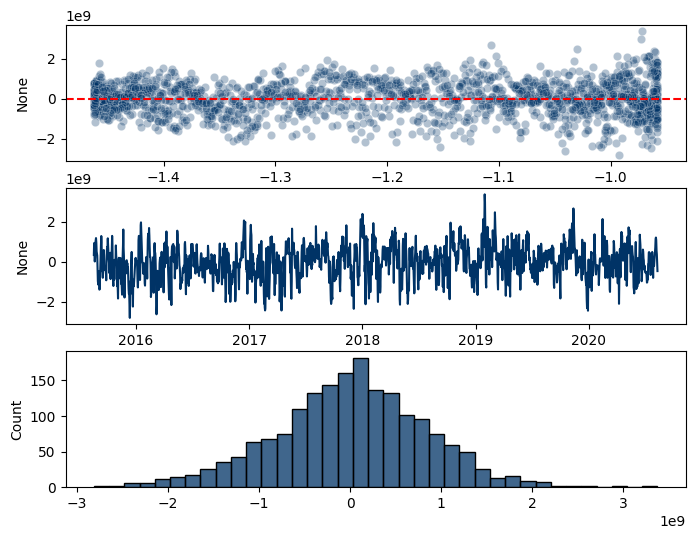

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.scatterplot(x=box_res.predict(box_X), y=box_res.resid, ax=ax[0], alpha=0.3)
ax[0].axhline(y=0, color='r', linestyle='--')

sns.lineplot(x=weather_df['time'], y=box_res.resid, ax=ax[1])

sns.histplot(box_res.resid, ax=ax[2])

plt.show()

Based on the residual plots, the Box–Cox transformation appears to handle heteroscedasticity better than the other transformations. However, this assessment is currently purely visual. To confirm, we will perform the Breusch–Pagan test to formally evaluate whether heteroscedasticity persists, using a 5% significance level to determine rejection of the null hypothesis.

- **Null hypothesis**: Residuals are homoscedastic.
- **Alternativa hypothesis**: Heteroscedasticity present.

In [26]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(box_res.resid, box_X)
f_pvalue

np.float64(2.8800324683117757e-15)

From the test above, we reject the null hypothesis, indicating that heteroscedasticity is still present. However, visually the heteroscedasticity appears less pronounced than in the other variables. The other residuals exhibit more prominent seasonal peaks and troughs, highlighting stronger seasonal heteroscedasticity compared to the Box–Cox–transformed data

In [27]:
box_predict = inv_box_transf(box_res.predict(box_X), lmbda)
residuals['box_resid'] = weather_df['tavg'] - box_predict

# Residuals Analysis
Now, let us examine the residuals to determine which method best fits our objective. The primary metric will be the interquartile range (IQR), chosen for its direct relationship with the width of the prediction interval, which we aim to minimize.

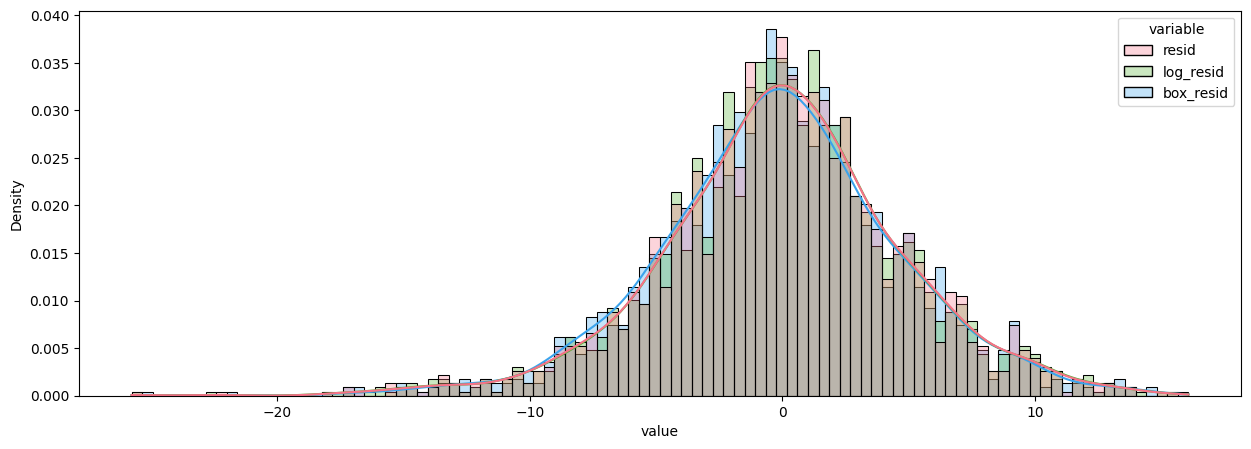

value                                                         \
            count      mean       std        min       25%           50%   
variable                                                                   
box_resid  1818.0 -0.135151  4.768111 -25.307251 -2.944185 -1.381558e-01   
log_resid  1818.0  0.005223  4.786964 -25.772273 -2.669768  8.111636e-05   
resid      1818.0  0.003244  4.780592 -25.745831 -2.669148 -3.195808e-08   

                                     IQR  
                75%        max            
variable                                  
box_resid  2.646176  16.084220  5.590361  
log_resid  2.743684  15.409378  5.413452  
resid      2.757424  15.587705  5.426572

In [28]:
df_resid = residuals.melt()

plt.figure(figsize=(15, 5))
sns.histplot(data=df_resid, x='value', hue='variable', stat='density', bins=100, kde=True, alpha=0.3)
plt.show()

desc_resid = df_resid.groupby('variable').describe()
desc_resid['IQR'] = desc_resid[('value',   '75%')] - desc_resid[('value',   '25%')]
desc_resid

Although the Box–Cox transformation appeared to handle heteroscedasticity most effectively, it performed the worst in terms of predictive ability, exhibiting both the highest IQR and the largest average residual error. The logarithmic transformation achieved a slightly smaller IQR, but this marginal improvement is outweighed by the considerably lower mean residual observed in the original data. Based on these results, we opt to proceed with the original data.

In [29]:
weather_df['y_hat'] = res.predict(X)
weather_df['resid'] = res.resid
weather_df.head()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal,log_tavg,box_tavg,y_hat,resid
0,2015-08-19,295.8,0.0,0.0,6.6,1004.8,8.3,Southwest,-5.689684,-1.403324e+10,297.100872,-1.300872
1,2015-08-20,292.8,0.0,0.0,6.6,1010.2,8.3,West,-5.679490,-1.342244e+10,297.001835,-4.201835
2,2015-08-21,295.8,0.0,0.0,3.9,1017.5,13.2,South,-5.689684,-1.403324e+10,296.899932,-1.099932
3,2015-08-22,297.1,0.0,0.0,4.1,1017.2,9.4,South,-5.694069,-1.430448e+10,296.795190,0.304810
4,2015-08-23,296.1,0.5,0.0,5.2,1011.3,7.8,Southwest,-5.690697,-1.409548e+10,296.687632,-0.587632


# Conclusion

In [30]:
DATA_PATH_WRANGLE.mkdir(parents=True, exist_ok=True)
weather_df.drop(columns=['log_tavg', 'box_tavg']).to_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_linear_resids.parquet'))